In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA 

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings('ignore')
np.random.seed(37)

In [2]:
# input
DATASET_PATH = 'course_project_train.csv'
TEST_PATH = 'course_project_test.csv'
PREP_DATASET_PATH = 'course_project_train_prep.csv'


# output
TRAIN_FULL_PATH = 'course_project_train_full.csv'
TRAIN_PART_PATH = 'course_project_train_part_b.csv'
TEST_PART_PATH = 'course_project_test_part.csv'

SCALER_FILE_PATH = 'scaler.pkl'
PCA_FILE_PATH = 'pca_transform.plk'

**Описание датасета**

* **Home Ownership** - статус собственности
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [3]:
df = pd.read_csv(DATASET_PATH)
df_base = pd.read_csv(DATASET_PATH)

df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [4]:
df_test = pd.read_csv(TEST_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [5]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
base_features = df.columns.drop(TARGET_NAME).tolist()
categorial_features = df.select_dtypes(include='object').columns.tolist()
num_features = df.select_dtypes(include='float64').columns.tolist()

X = df[base_features]
y_target = df[TARGET_NAME]

### Обзор данных<a class="anchor" id="review"></a>

**Обзор целевой переменной**

In [8]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [9]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [10]:
# 1.2. Пропущенные данные и уникальные данные

def show_nans(df):
    for col in df.columns:
        print(col,5*'.',': number of unique:',len(df[col].unique()),':   number of nan records: ',df[col].isna().sum())
        print(30*'-')

In [11]:
# 1.2.2. Пропущенные данные и уникальные данные. Train dataset
show_nans(df)

Home Ownership ..... : number of unique: 4 :   number of nan records:  0
------------------------------
Annual Income ..... : number of unique: 5479 :   number of nan records:  1557
------------------------------
Years in current job ..... : number of unique: 12 :   number of nan records:  371
------------------------------
Tax Liens ..... : number of unique: 8 :   number of nan records:  0
------------------------------
Number of Open Accounts ..... : number of unique: 39 :   number of nan records:  0
------------------------------
Years of Credit History ..... : number of unique: 408 :   number of nan records:  0
------------------------------
Maximum Open Credit ..... : number of unique: 6963 :   number of nan records:  0
------------------------------
Number of Credit Problems ..... : number of unique: 8 :   number of nan records:  0
------------------------------
Months since last delinquent ..... : number of unique: 90 :   number of nan records:  4081
----------------------------

In [12]:
# 1.2.3 Пропущенные данные и уникальные данные. Test dataset
show_nans(df_test)

Home Ownership ..... : number of unique: 4 :   number of nan records:  0
------------------------------
Annual Income ..... : number of unique: 1930 :   number of nan records:  513
------------------------------
Years in current job ..... : number of unique: 12 :   number of nan records:  86
------------------------------
Tax Liens ..... : number of unique: 8 :   number of nan records:  0
------------------------------
Number of Open Accounts ..... : number of unique: 35 :   number of nan records:  0
------------------------------
Years of Credit History ..... : number of unique: 345 :   number of nan records:  0
------------------------------
Maximum Open Credit ..... : number of unique: 2435 :   number of nan records:  0
------------------------------
Number of Credit Problems ..... : number of unique: 8 :   number of nan records:  0
------------------------------
Months since last delinquent ..... : number of unique: 84 :   number of nan records:  1358
------------------------------

In [13]:
def correlation(
    df: pd.DataFrame, 
    target: str, 
    to_sort: str = None, 
    to_drop: str = None
) -> [print, plt.plot]:
    
    """calculates correlation whith target and plots graph"""
    
    corr_table = df.corr()
    
    result = corr_table.drop([to_drop], axis=0) if to_drop != None else corr_table
    sort_values = result.sort_values(to_sort, ascending=False)*100 if to_sort != None else result
    
    coef = round(sort_values[target], 2)
    
    print(coef)
    
    plt.figure(figsize=(12,10))

    plt.barh(coef.index, coef.values)

    plt.title(f'Correlation with {target}', fontsize=16)
    plt.xlabel('percent', fontsize=14)
    
    plt.grid()

Credit Score                    44.21
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Months since last delinquent     0.26
Bankruptcies                     0.16
Maximum Open Credit             -1.43
Current Credit Balance          -1.95
Years of Credit History         -2.06
Annual Income                  -10.14
Current Loan Amount            -22.65
Name: Credit Default, dtype: float64


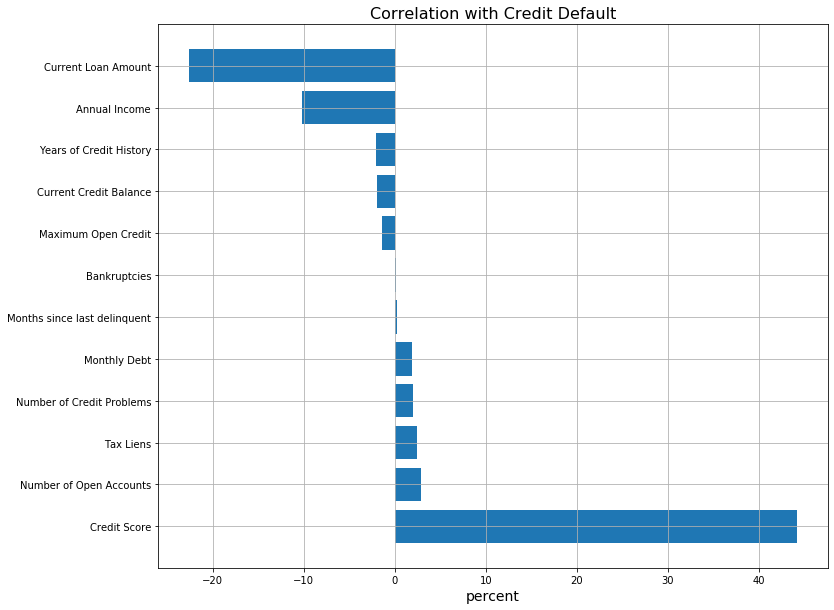

In [14]:
feauter = 'Credit Default'

correlation(df, target=feauter, to_drop=feauter, to_sort=feauter)

Как мы видим, большое значение корелляции только у Credit Score, а также у двух параметров большая отрицательная корелляция. 

In [15]:
# 1.2.4. Визуальное изучение распределений - пользовательская функция
def plot_outliers(df_train, df_test, col_name, hist = False):
    fig, ax = plt.subplots(1,3,figsize=(16,5))
    #ax[0].set_title(f'KDE for both datasets on {col_name}')
    ax[1].set_title('Train Dataset')
    ax[2].set_title('Test Dataset')
    sns.distplot(df_train[col_name], color='b', ax=ax[0], hist=hist, label='Train', kde_kws={'bw': 1.5})
    sns.distplot(df_test[col_name], color='r', ax=ax[0], hist=hist, label='Test', kde_kws={'bw': 1.5})
    sns.boxplot(df_train[col_name], ax=ax[1])
    sns.boxplot(df_test[col_name], color='r', ax=ax[2])
    plt.show()

In [16]:
df.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

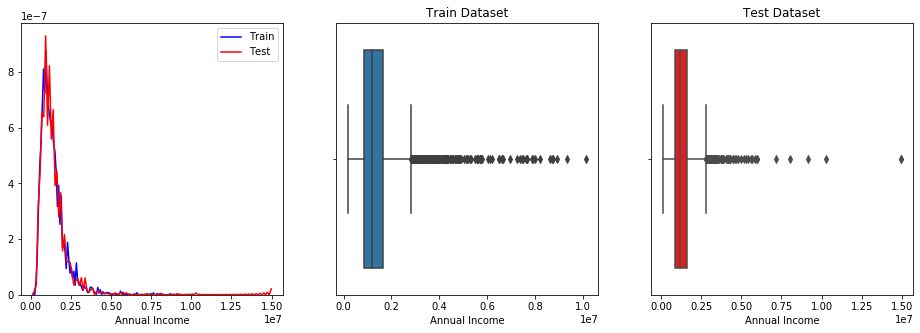

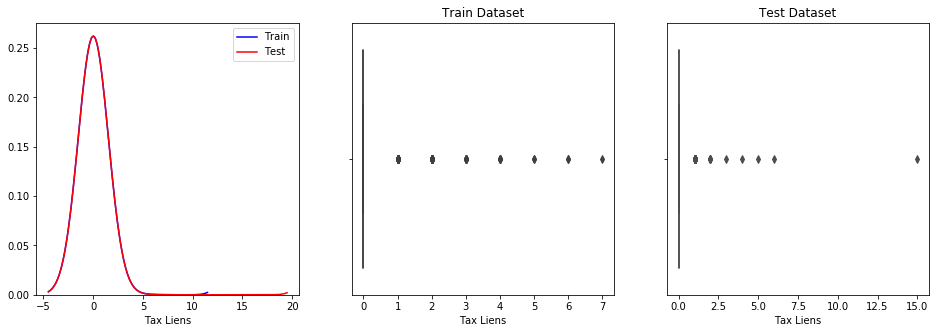

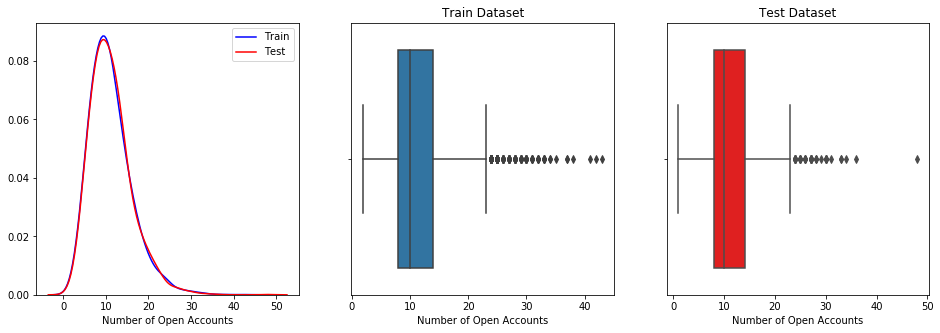

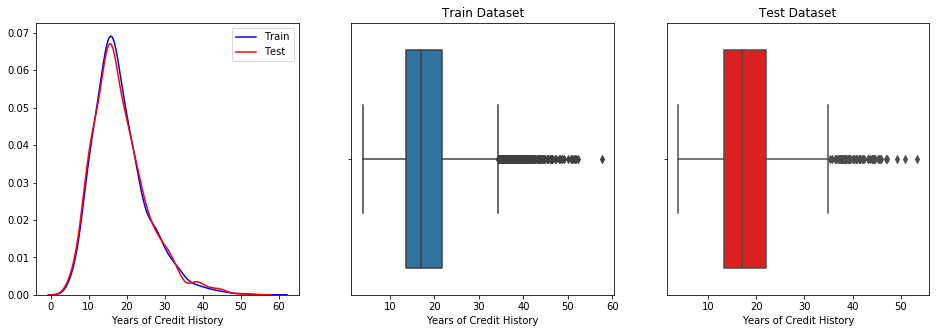

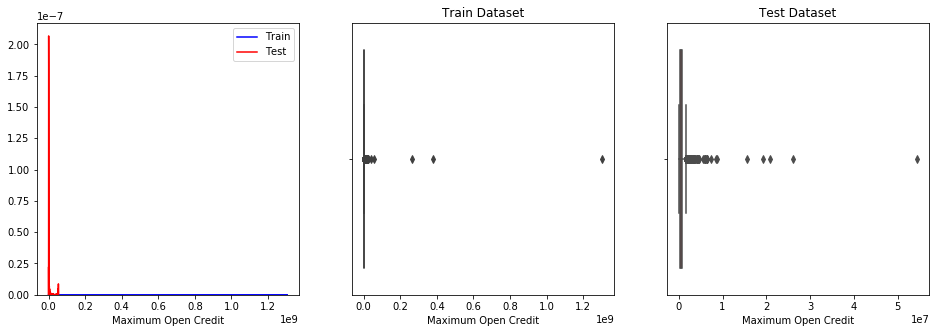

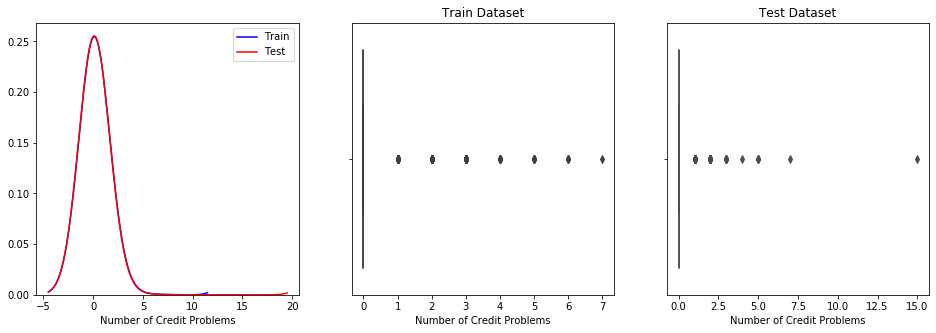

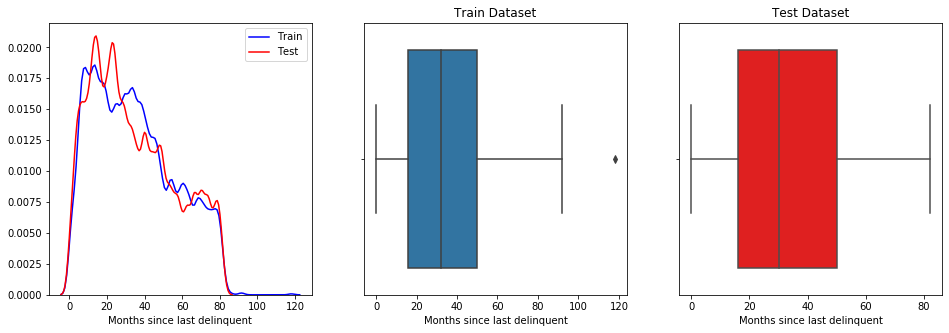

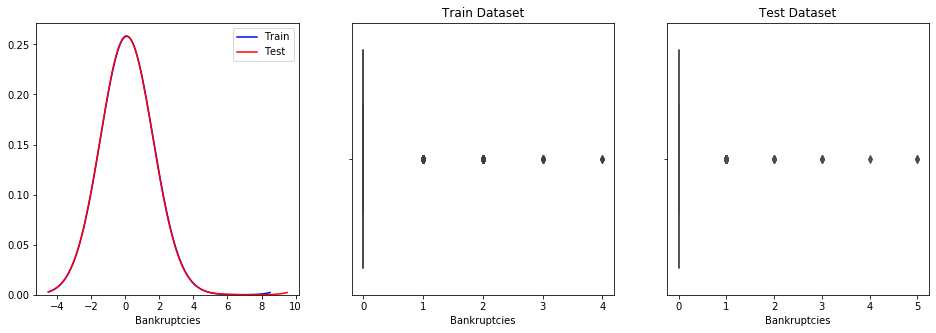

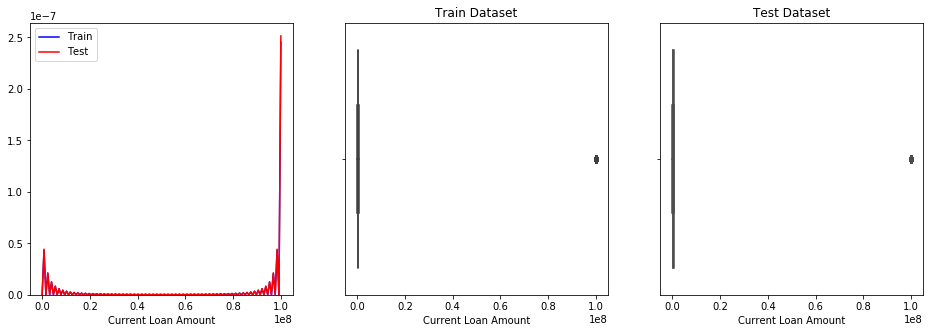

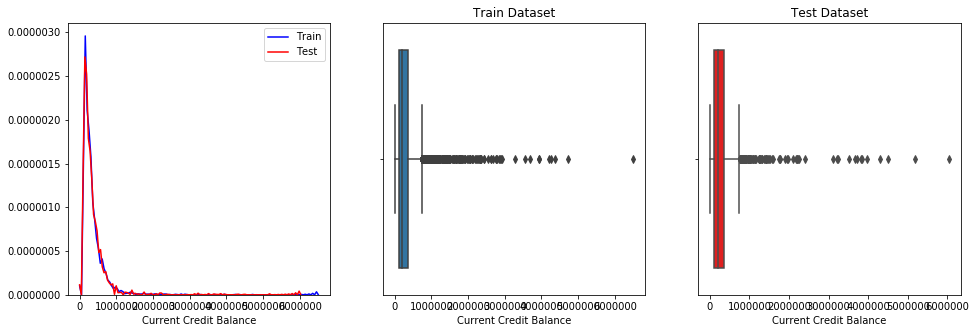

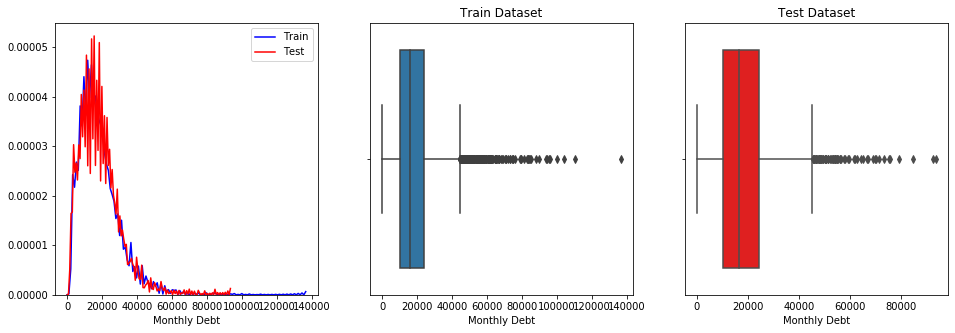

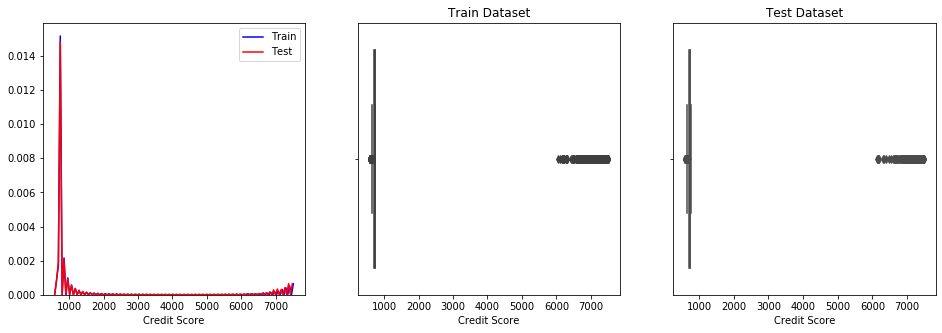

In [18]:
# 1.2.5. Визуальное изучение распределений - непрерывные данные

cont_cols = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

cat_cols =['Home Ownership', 'Years in current job', 'Tax Liens', 'Purpose', 'Term']

TARGET = ['Credit Default']


for col in cont_cols:
    plot_outliers(df, df_test,col)

## Согласованность категориальных данных
 исследуем категориальные данные на предмет полноты в обоих выборках

In [19]:
def plot_outliers_cat(df_train,df_test, col_name,  TARGET_NAME = TARGET):
    fig, ax = plt.subplots(1,2,figsize=(16,5))
   
    ax[0].set_title('Train Dataset')
    ax[1].set_title('Test Dataset')   

    sns.countplot(x=col_name, data=df_train, ax=ax[0]);
    sns.countplot(x=col_name, data=df_test, ax=ax[1]);
    plt.show()

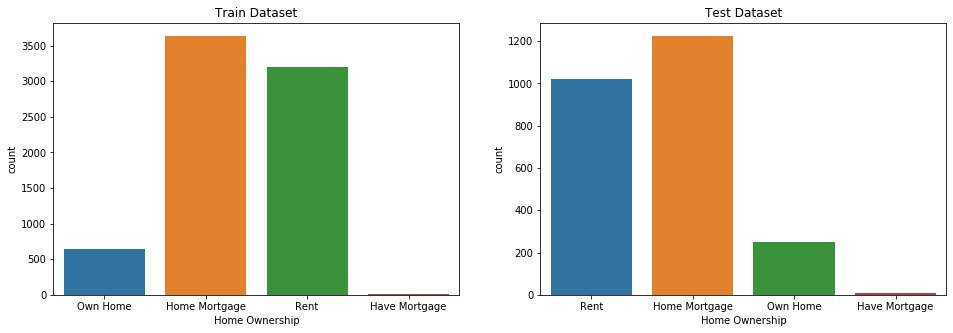

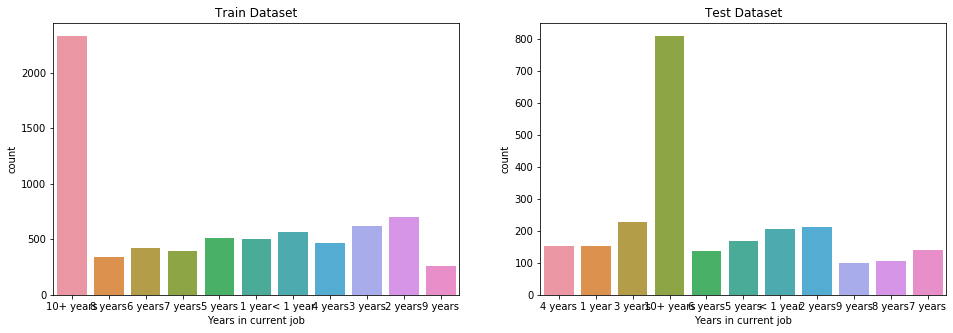

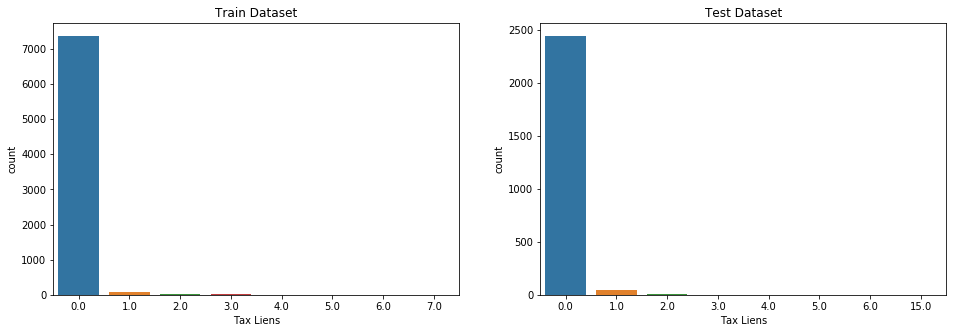

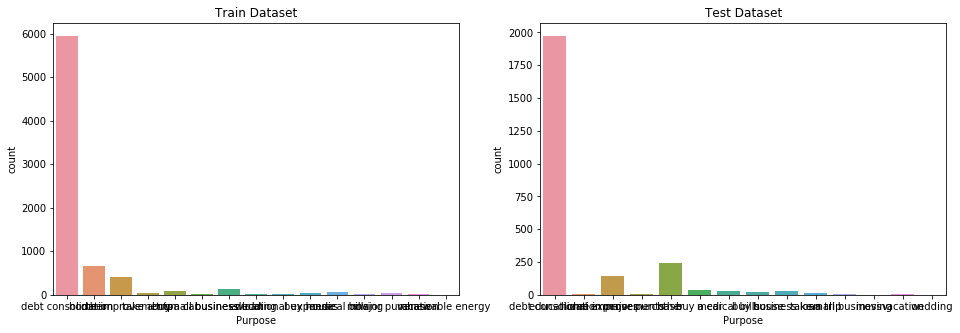

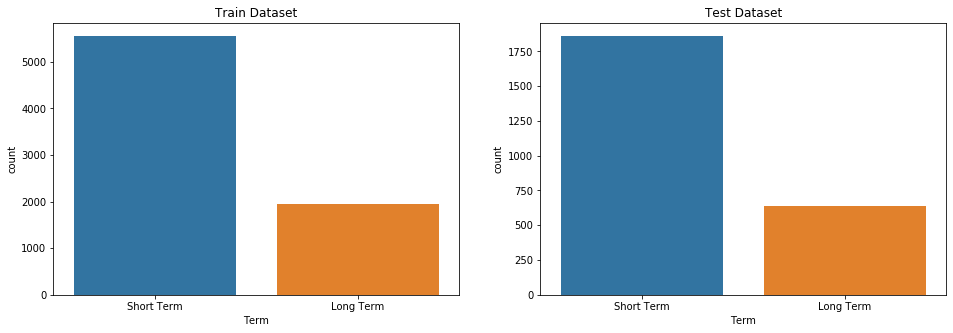

In [20]:
for col in cat_cols:
    plot_outliers_cat(df,df_test, col, TARGET_NAME = TARGET)

In [21]:
def countplot(df,feature,target = TARGET_NAME):
    
    plt.figure(figsize=(20, 15))

    sns.countplot(x=feature, hue=TARGET_NAME, data=df)
    plt.title(f'{feature} grouped by target variable')
    plt.legend(title='Target', loc='upper right')

    plt.show()

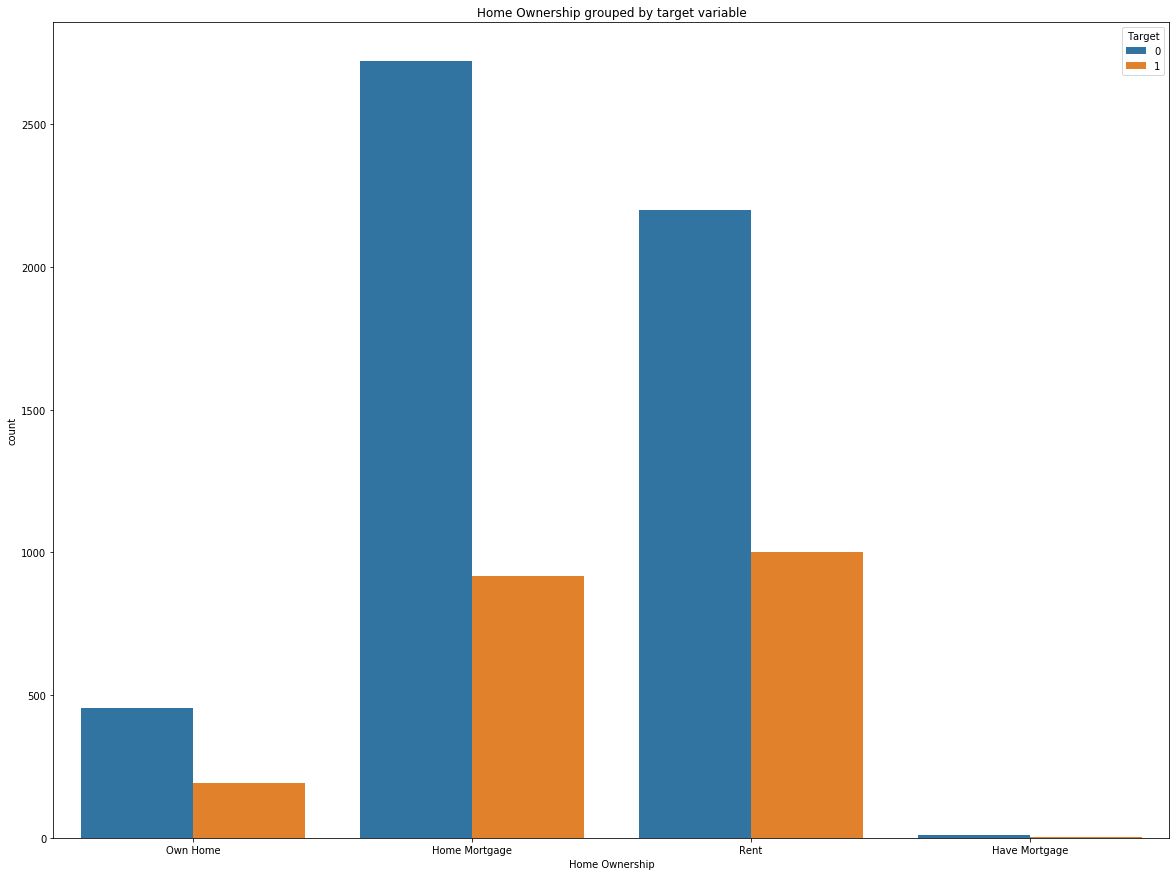

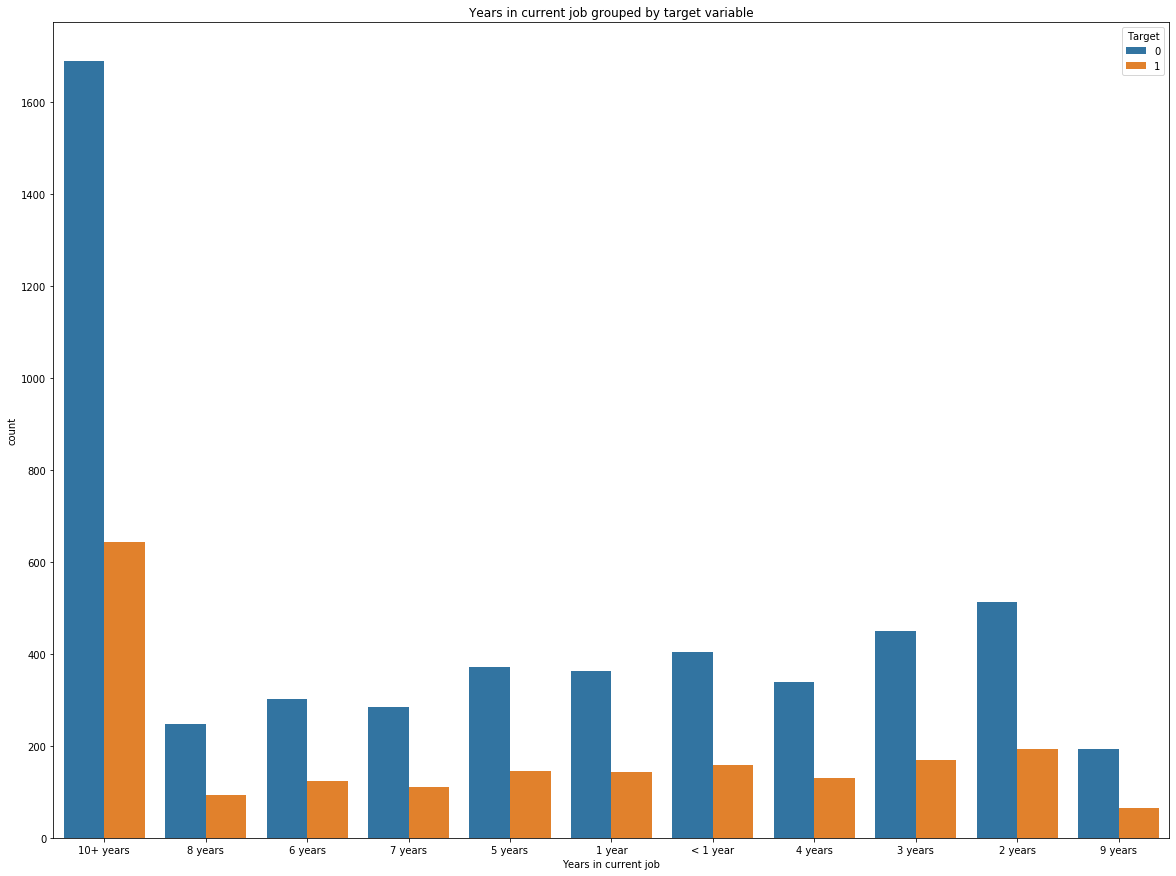

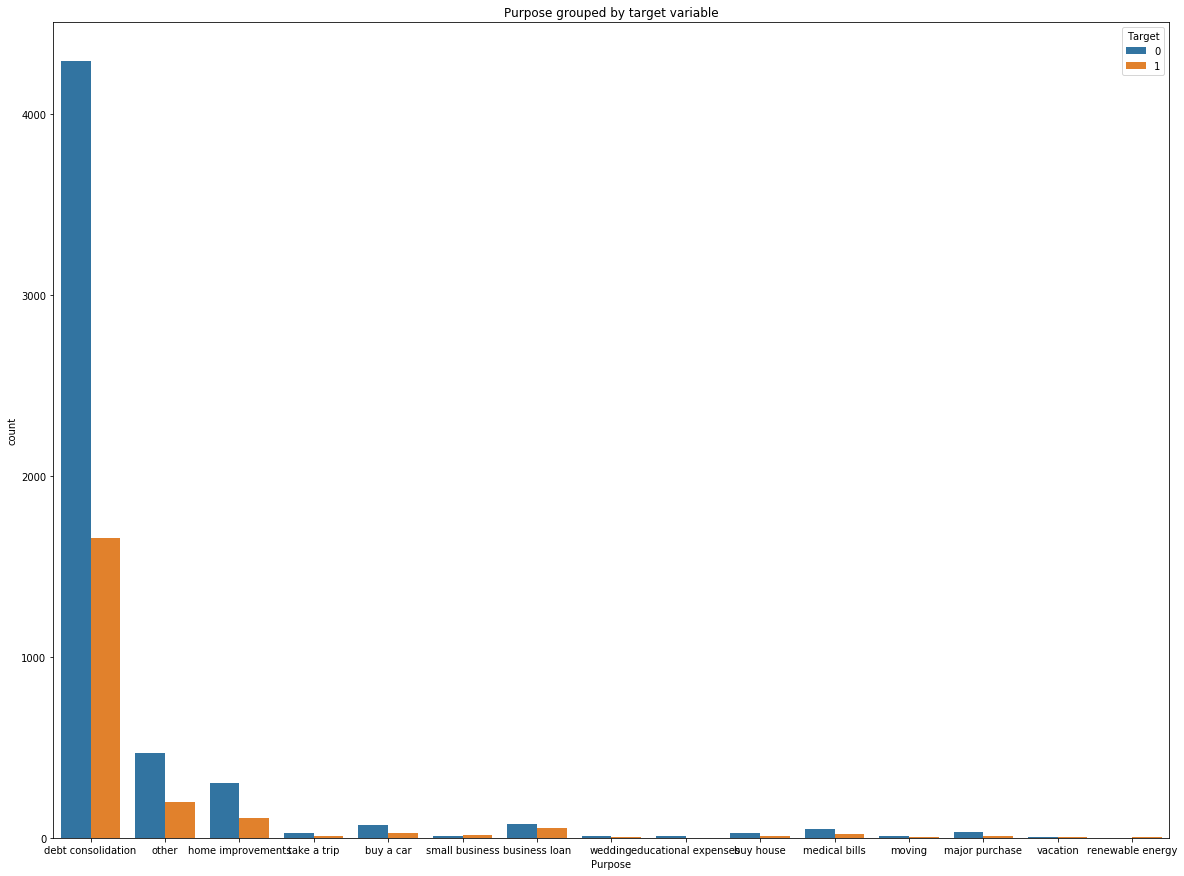

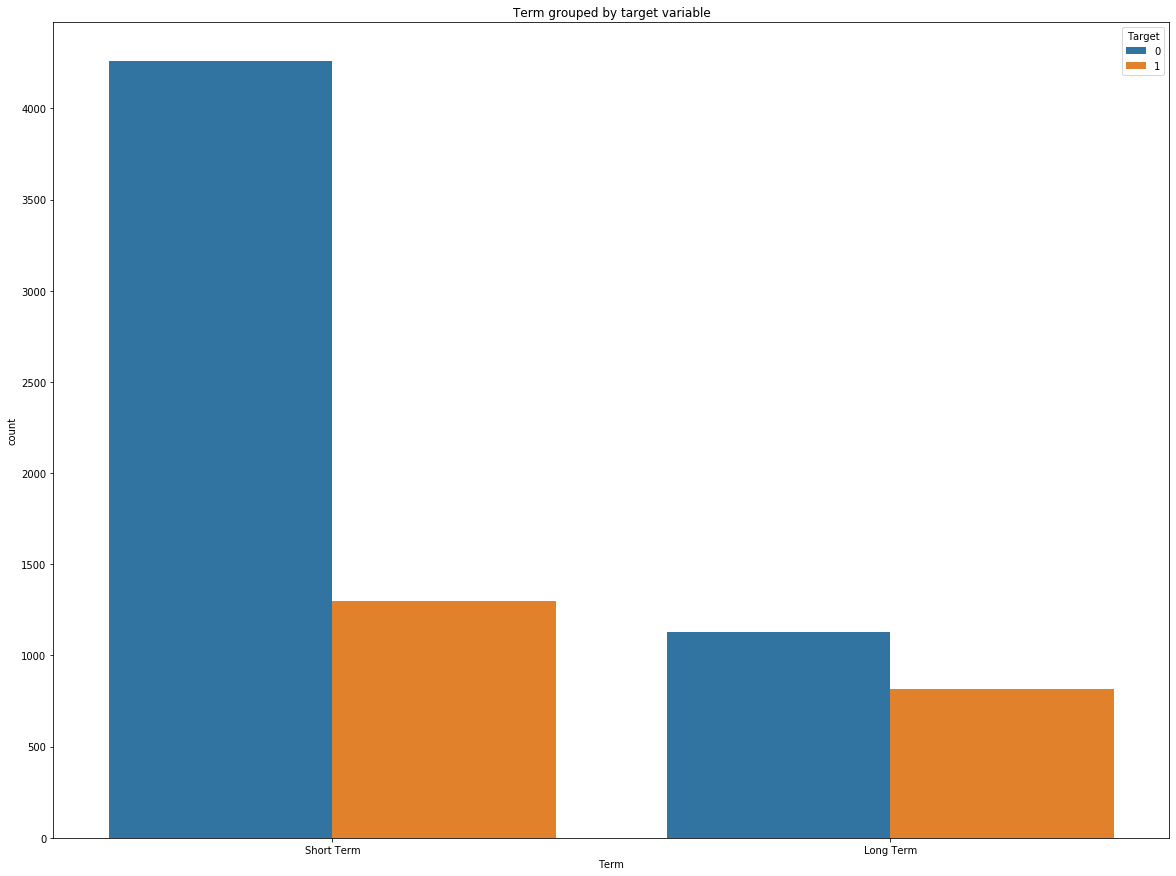

In [22]:
for feature in categorial_features:
    countplot(df,feature)

В каждой из категориальных групп мы видим примерно одинаковый расклад - просроченных кредитов меньше, чем выплаченных вовремя.

In [23]:
def plot_by_target(df,feature,target):
    X = df[[feature,target]]
    X_0 = X.loc[X[target]==0,feature]
    X_1 = X.loc[X[target]==1,feature]
    
    plt.figure(figsize=(10, 5))

    sns.kdeplot(X_0, shade=True, label='0', color='g', bw = 1.5)
    sns.kdeplot(X_1, shade=True, label='1', color='r', bw = 1.5)

    plt.xlabel(f'{feature}')
    plt.title(f'{feature} grouped by target variable')
    plt.show()

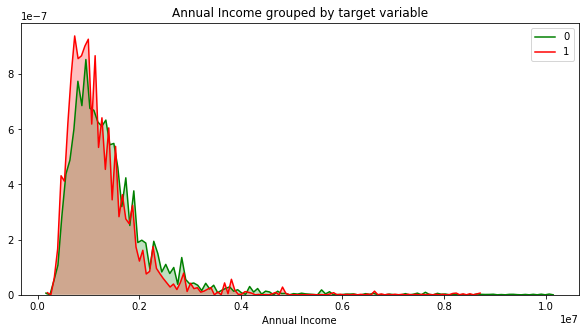

In [24]:
plot_by_target(df,'Annual Income',TARGET_NAME)


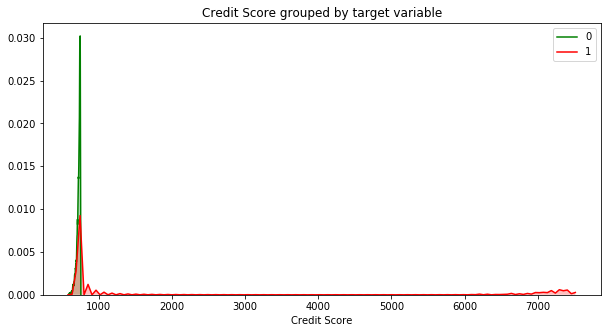

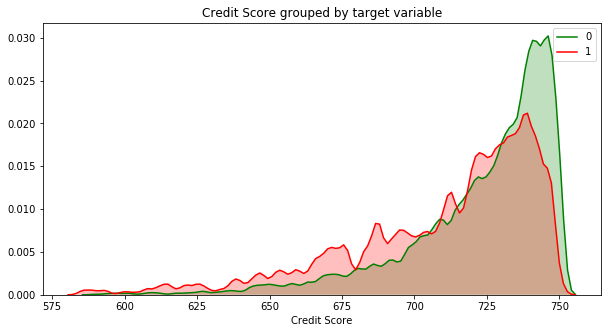

In [25]:
plot_by_target(df,'Credit Score',TARGET_NAME)
plot_by_target(df[df['Credit Score']<800],'Credit Score',TARGET_NAME)


После исключения выбросов (больше 800) мы видим логичную картину, что чем больше кредитный рейтинг, тем больше вероятность выплаты в срок

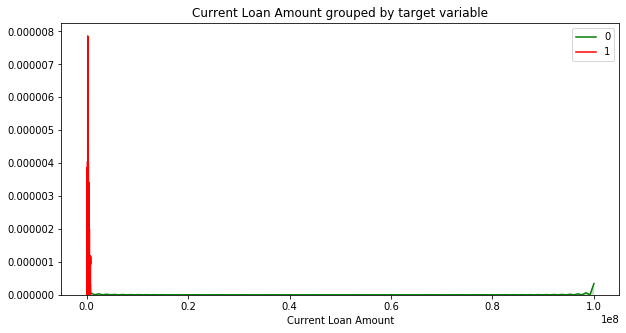

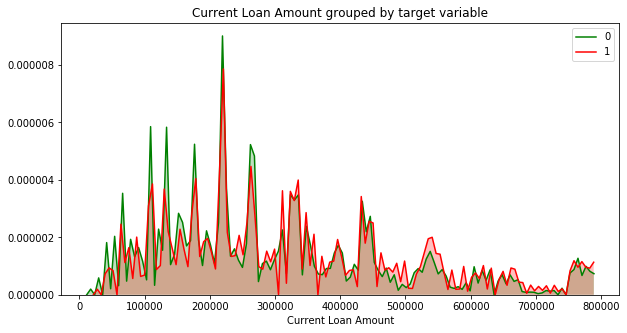

In [26]:
plot_by_target(df,'Current Loan Amount',TARGET_NAME)
plot_by_target(df[df['Current Loan Amount']<1000000],'Current Loan Amount',TARGET_NAME)


В целом данные по сумме кредита распределены схожим образом, но с некоторым ростом невыплаты при увеличении суммы. 

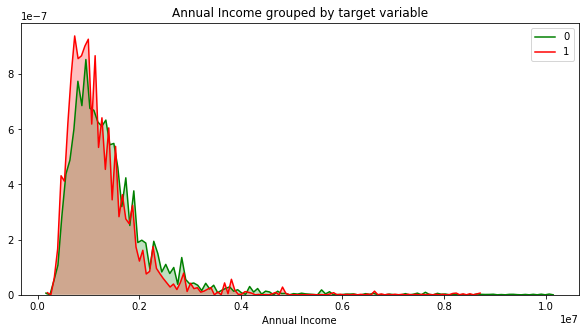

In [27]:
plot_by_target(df,'Annual Income',TARGET_NAME)

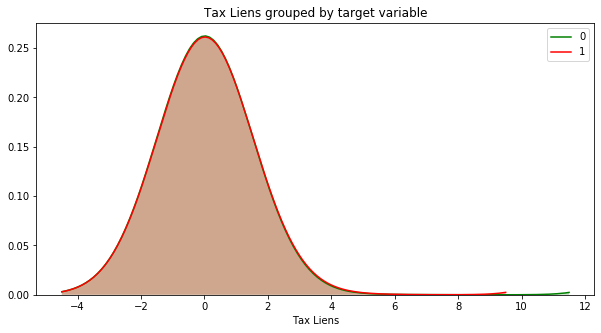

In [28]:
plot_by_target(df,'Tax Liens',TARGET_NAME)

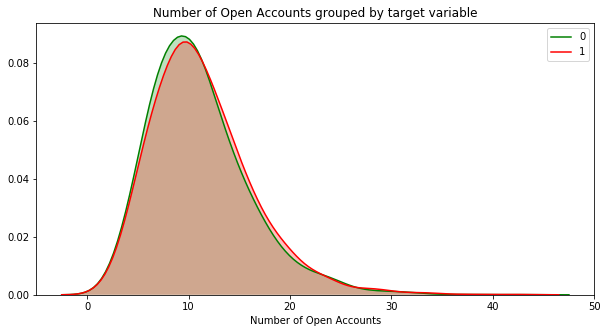

In [29]:
plot_by_target(df,'Number of Open Accounts',TARGET_NAME)

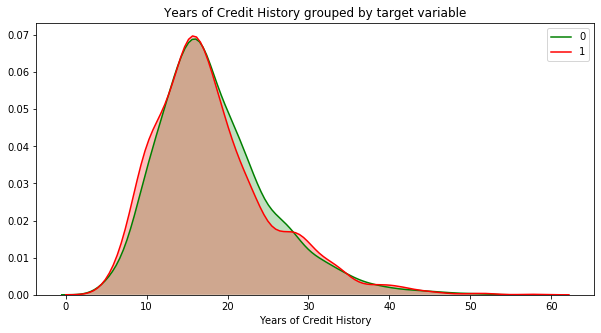

In [30]:
plot_by_target(df,'Years of Credit History',TARGET_NAME)

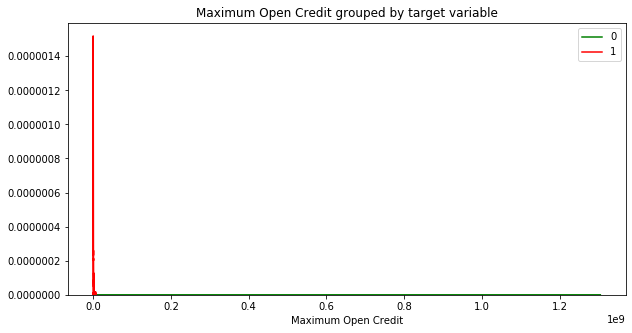

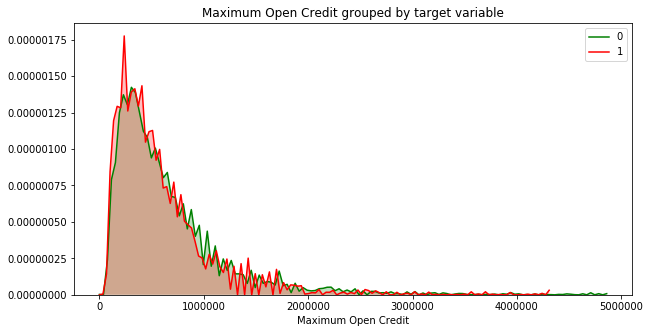

In [31]:
plot_by_target(df,'Maximum Open Credit',TARGET_NAME)
plot_by_target(df[df['Maximum Open Credit']<5000000],'Maximum Open Credit',TARGET_NAME)


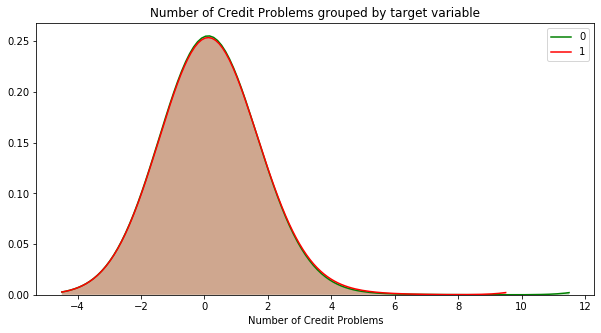

In [32]:
plot_by_target(df,'Number of Credit Problems',TARGET_NAME)

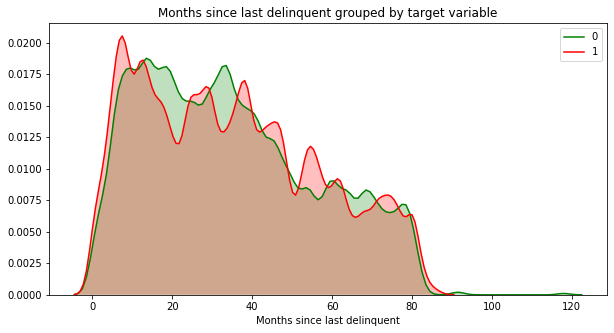

In [33]:
plot_by_target(df,'Months since last delinquent',TARGET_NAME)

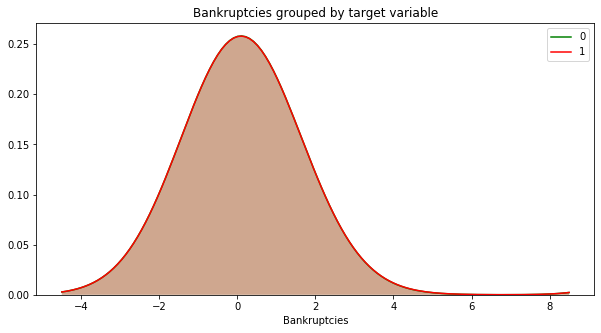

In [34]:
plot_by_target(df,'Bankruptcies',TARGET_NAME)

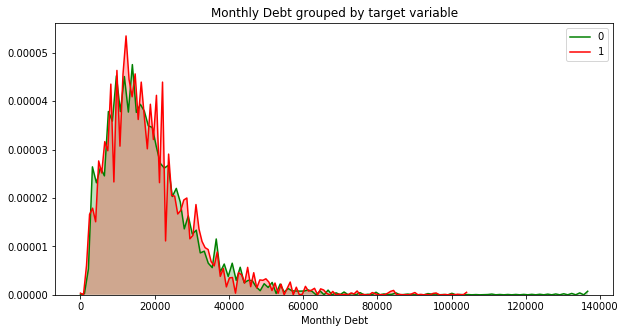

In [35]:
plot_by_target(df,'Monthly Debt',TARGET_NAME)

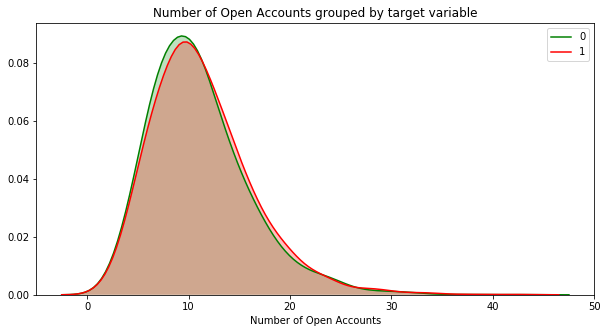

In [36]:
plot_by_target(df,'Number of Open Accounts',TARGET_NAME)

Мы видим, что в целом все параметры распределены одинаково, некоторые даже имеют идентичный график. 
Рассмотрим отдельно Home Ownership (отсутсвует в трейне Rent) и Purpose. 

Учитывая небольшую частоту остальных показателей и разный набор параметров в тесте и трейне оставим Три категории - debt consolidation и other, в которую внесем все остальное. Третья будет Business loan, т.к. это единственная, где значения 0 и 1 практически равны. 

**Обзор количественных признаков**

In [37]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [38]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [39]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

Мы видим достаточно большое количество пропусков в графах 'Annual Income', 'Years in current job', 'Months since last delinquent', 'Credit Score'. Небольшое количество пропусков в 'Bankruptcies'.
Также при осмотре данных видны выбросы в 'Credit Score'. Начнем с них

In [40]:
df['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [41]:
df['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

Т.к. большее количество показателей этого параметра трехзначные, значит четырехзначные являются умноженными на 10. В тренировочных данных выброс начинается после 751, но для ситуации корректных данных в тесте возьмем границу 800. Однако, заполнение этих значений путем деления на 10 сильно ухудшает корелляцию и общий результат модели. Поэтому, для данных значений возмем среднее. 

In [42]:
df[df['Number of Credit Problems'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


Выводы из этого и последущих моментов см. далее в функции FeatureImputer

In [43]:
df[df['Current Loan Amount'] == 99999999.0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,49438.0,18257.0,737.0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,83638.0,16473.0,742.0,0


In [44]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

**Обзор номинативных признаков**

In [45]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [46]:
import pickle

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

def omission(df, feature_target):
    scx_ = StandardScaler()
    scy_ = StandardScaler()

    feature_pred = ['Tax Liens', 'Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                    'Number of Credit Problems','Current Loan Amount','Current Credit Balance','Monthly Debt']
    
    xdf_train = df.loc[(df[feature_target].isna() == False),feature_pred].copy()
    xdf_test = df.loc[(df[feature_target].isna() == True),feature_pred].copy()
    ydf_train = df.loc[(df[feature_target].isna() == False),feature_target].copy()

     # нормирование
    xdf_trainS = scx_.fit_transform(xdf_train)
    xdf_testS = scx_.transform(xdf_test)

    ydf_trainS = scy_.fit_transform(ydf_train.values.reshape( -1,1))

    # заполнение пробелов по линейной регресиии
    #lr_pay4 = LinearRegression()
    lr_pay4 = RandomForestRegressor()

    lr_pay4=lr_pay4.fit(xdf_trainS, ydf_trainS)
    y_testS = lr_pay4.predict(xdf_testS)

    y_test = scy_.inverse_transform(y_testS.reshape(-1,1))

    with open('imputer_scaler_x.pkl', 'wb') as file:
        pickle.dump(scx_, file)
    with open('imputer_scaler_y.pkl', 'wb') as file:
        pickle.dump(scy_, file)
    with open('imputer_regress_xy.pkl', 'wb') as file:
        pickle.dump(lr_pay4, file)    

    print(y_test[:5])

    y_t = lr_pay4.predict(xdf_trainS)
    plt.plot(y_t,ydf_trainS,'.')
    plt.title('оценка регресиии')
    plt.show()
    df.loc[(df[feature_target].isna() == True),feature_target]=y_test[:,0]

[[1325093.63]
 [ 755919.56]
 [1578964.79]
 [1136776.46]
 [1537451.69]]


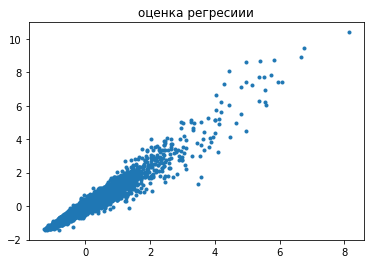

[[ 599207.94]
 [ 687395.68]
 [1638908.65]
 [1399195.72]
 [1494131.88]]


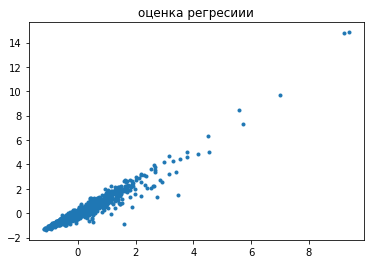

In [48]:
omission(df, 'Annual Income')
omission(df_test, 'Annual Income')

[[50.16]
 [33.54]
 [26.42]
 [42.54]
 [39.15]]


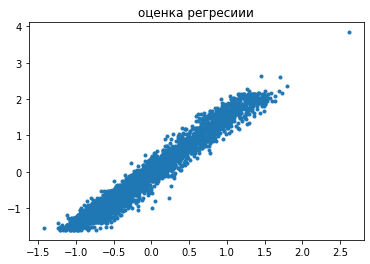

[[29.51]
 [24.64]
 [34.57]
 [31.79]
 [28.27]]


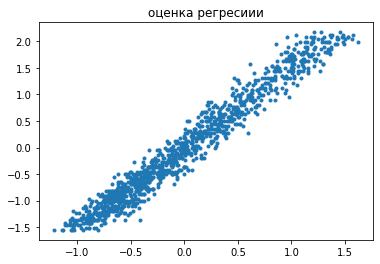

In [49]:
omission(df, 'Months since last delinquent')
omission(df_test, 'Months since last delinquent')

[[2.67841305e-15]
 [2.67841305e-15]
 [2.67841305e-15]
 [2.67841305e-15]
 [2.67841305e-15]]


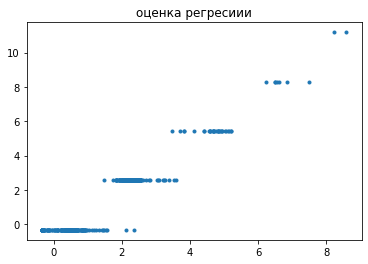

[[1.1379786e-15]
 [1.1379786e-15]
 [1.1379786e-15]]


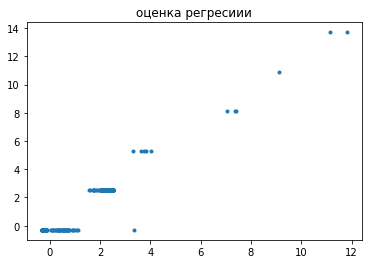

In [50]:
omission(df, 'Bankruptcies')
omission(df_test, 'Bankruptcies')

In [51]:
df.loc[df['Credit Score'] > 999, 'Credit Score'] = df['Credit Score'].median()
df_test.loc[df_test['Credit Score'] > 999, 'Credit Score'] = df_test['Credit Score'].median()

[[705.13]
 [719.65]
 [708.65]
 [723.22]
 [722.43]]


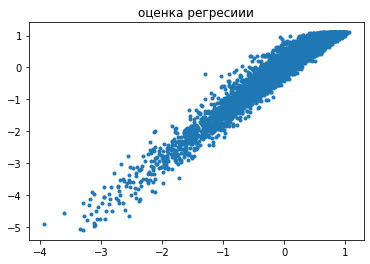

[[721.45]
 [721.56]
 [691.07]
 [739.72]
 [714.75]]


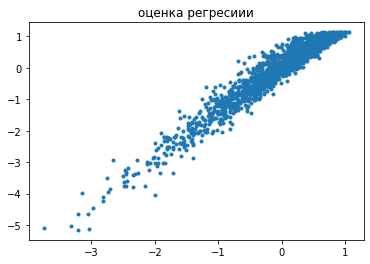

In [52]:
omission(df, 'Credit Score')
omission(df_test, 'Credit Score')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [54]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.370289e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,35.253512,0.116933,1.187318e+07,2.898332e+05,18314.454133,720.984071,0.281733
std,8.009902e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,15.481392,0.346904,3.192612e+07,3.178714e+05,11926.764673,24.471374,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.728891e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,27.350000,0.000000,1.801690e+05,1.142565e+05,10067.500000,712.000000,0.000000
50%,1.199081e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,34.780000,0.000000,3.095730e+05,2.093230e+05,16076.500000,727.015000,0.000000
75%,1.636386e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,42.140000,0.000000,5.198820e+05,3.604062e+05,23818.000000,738.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,751.000000,1.000000


In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [56]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

        
    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        
        #У признака Current Loan Amount есть явные выбросы - значения 99999999.0. Используем медиану, т.к. именно этот выброс является модой.
        df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = df['Current Loan Amount'].median()

        
        #Обработка категориальных признаков
        
        #У 'Home Ownership' есть два похожих значения, одно из которых небольшое, объединим в одну группу - 'Home Mortgage' и 'Have Mortgage'.
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
        
        #Переведем количество лет на данной работе в количественный признак. пропуски заполним модой
        years = {'10+ years': 10, '2 years': 2, '3 years': 3, '< 1 year': 0, '5 years': 5, 
                 '1 year': 1, '4 years': 4, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9}

        df['Years in current job'] = df['Years in current job'].map(years).astype(float)
        df['Years in current job'].fillna(df['Years in current job'].mode()[0], inplace=True)

        
        #У Purpose есть похожие параметры, объединим их в одни значения. параметры с небольшим количеством значений отнесем к Other
        df.loc[df['Purpose'] == 'buy house', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'moving', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'small business', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'vacation', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'educational expenses', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'home improvements', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'buy a car', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'wedding', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'medical bills', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'major purchase', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'small business', 'Purpose'] = 'other'
        
        # преобразование бинарных признаков
        df['Term_2'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

        # преобразовываем категориальные признаки в dummy признаки
        for cat_colname in df.select_dtypes(include='object').columns:
            df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
            
        #Генерация новых признаков
        df['Credit_burden'] = df['Annual Income']/12 - df['Monthly Debt']
            
        return df

In [57]:
imputer = FeatureImputer()

imputer.fit(df)

df = imputer.transform(df)
df_test = imputer.transform(df_test)

In [58]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_other,Purpose_take a trip,Term_Long Term,Term_Short Term,Credit_burden
0,Own Home,482087.0,10.0,0.0,11.0,26.3,685960.0,1.0,50.16,1.0,...,0,1,0,0,1,0,0,0,1,32259.916667
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,33.54,0.0,...,0,1,0,0,1,0,0,1,0,67084.250000
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,26.42,0.0,...,1,0,0,0,1,0,0,0,1,48966.666667
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,42.54,1.0,...,0,1,0,0,1,0,0,0,1,55751.000000
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,39.15,0.0,...,0,0,1,0,1,0,0,0,1,57508.666667


In [59]:
df[df.isnull().any(axis=1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_other,Purpose_take a trip,Term_Long Term,Term_Short Term,Credit_burden


In [60]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_other,Purpose_take a trip,Term_Long Term,Term_Short Term,Credit_burden
0,Rent,599207.94,4.0,0.0,9.0,12.5,220968.0,0.0,70.00,0.0,...,0,0,1,0,1,0,0,0,1,43120.995000
1,Rent,231838.00,1.0,0.0,6.0,32.7,55946.0,0.0,8.00,0.0,...,0,0,1,0,0,1,0,0,1,17001.833333
2,Home Mortgage,1152540.00,3.0,0.0,10.0,13.7,204600.0,0.0,29.51,0.0,...,1,0,0,0,1,0,0,0,1,77316.000000
3,Home Mortgage,1220313.00,10.0,0.0,16.0,17.0,456302.0,0.0,70.00,0.0,...,1,0,0,0,1,0,0,0,1,74133.750000
4,Home Mortgage,2340952.00,6.0,0.0,11.0,23.6,1207272.0,0.0,24.64,0.0,...,1,0,0,0,1,0,0,1,0,152474.333333


In [61]:
df_test[df_test.isnull().any(axis=1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_business loan,Purpose_debt consolidation,Purpose_other,Purpose_take a trip,Term_Long Term,Term_Short Term,Credit_burden


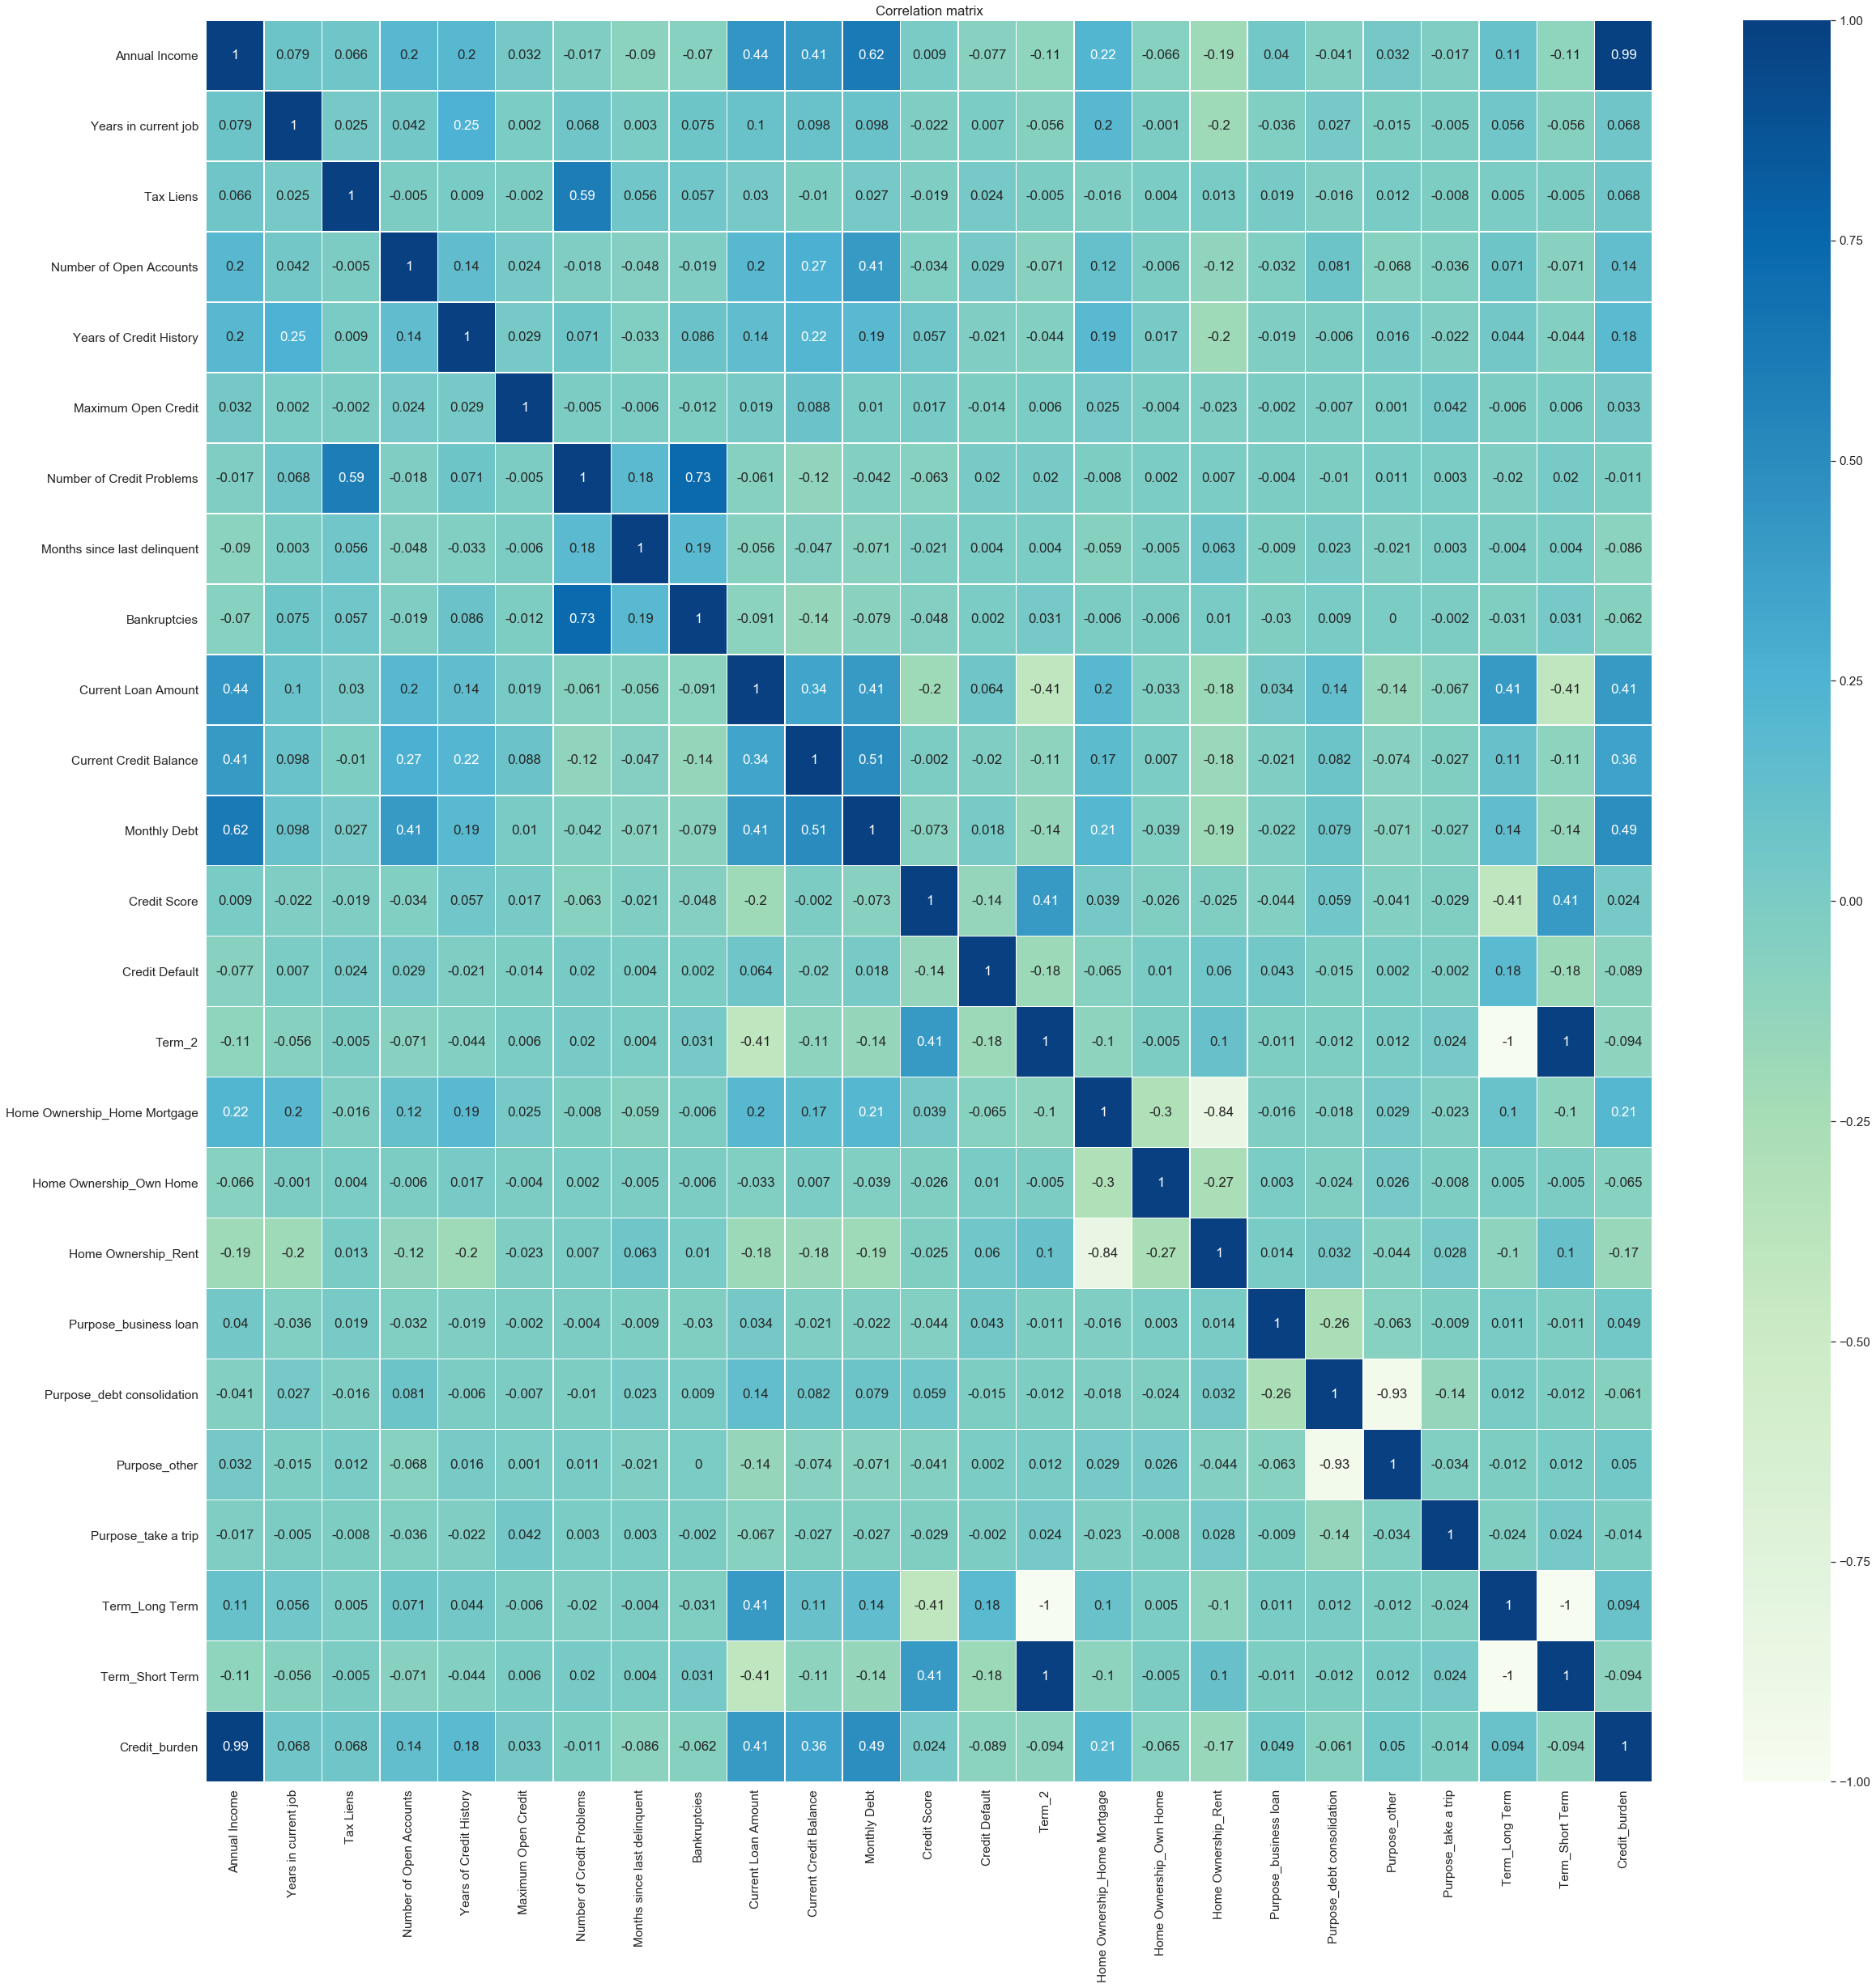

In [62]:
plt.figure(figsize = (40,40))

sns.set(font_scale=1.4)
sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Term_Long Term                  18.15
Current Loan Amount              6.42
Home Ownership_Rent              6.01
Purpose_business loan            4.25
Number of Open Accounts          2.89
Tax Liens                        2.44
Number of Credit Problems        2.01
Monthly Debt                     1.85
Home Ownership_Own Home          1.03
Years in current job             0.68
Months since last delinquent     0.41
Purpose_other                    0.18
Bankruptcies                     0.16
Purpose_take a trip             -0.18
Maximum Open Credit             -1.43
Purpose_debt consolidation      -1.51
Current Credit Balance          -1.95
Years of Credit History         -2.06
Home Ownership_Home Mortgage    -6.53
Annual Income                   -7.69
Credit_burden                   -8.91
Credit Score                   -13.95
Term_2                         -18.15
Term_Short Term                -18.15
Name: Credit Default, dtype: float64


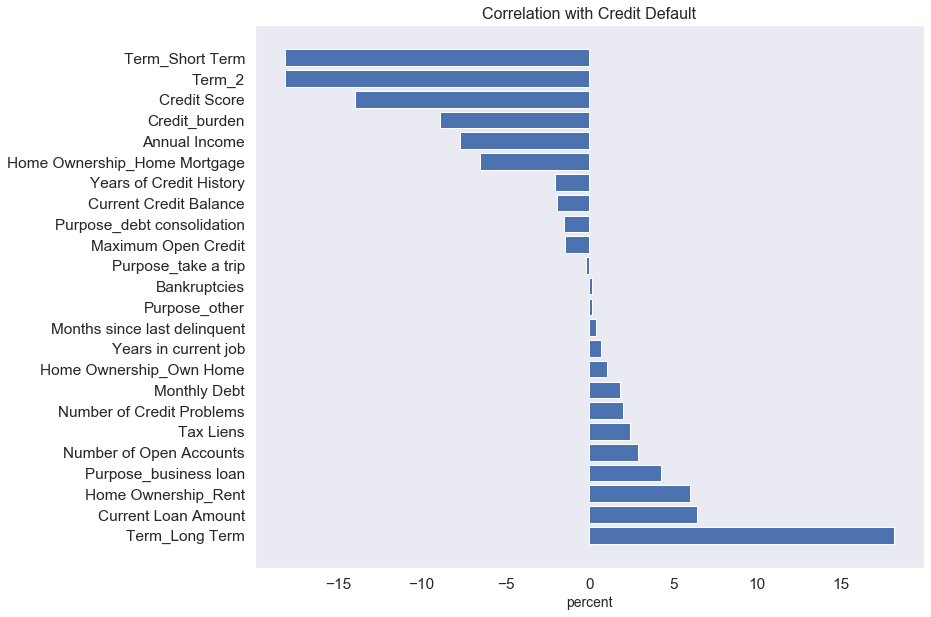

In [63]:
feauter = 'Credit Default'

correlation(df, target=feauter, to_drop=feauter, to_sort=feauter)

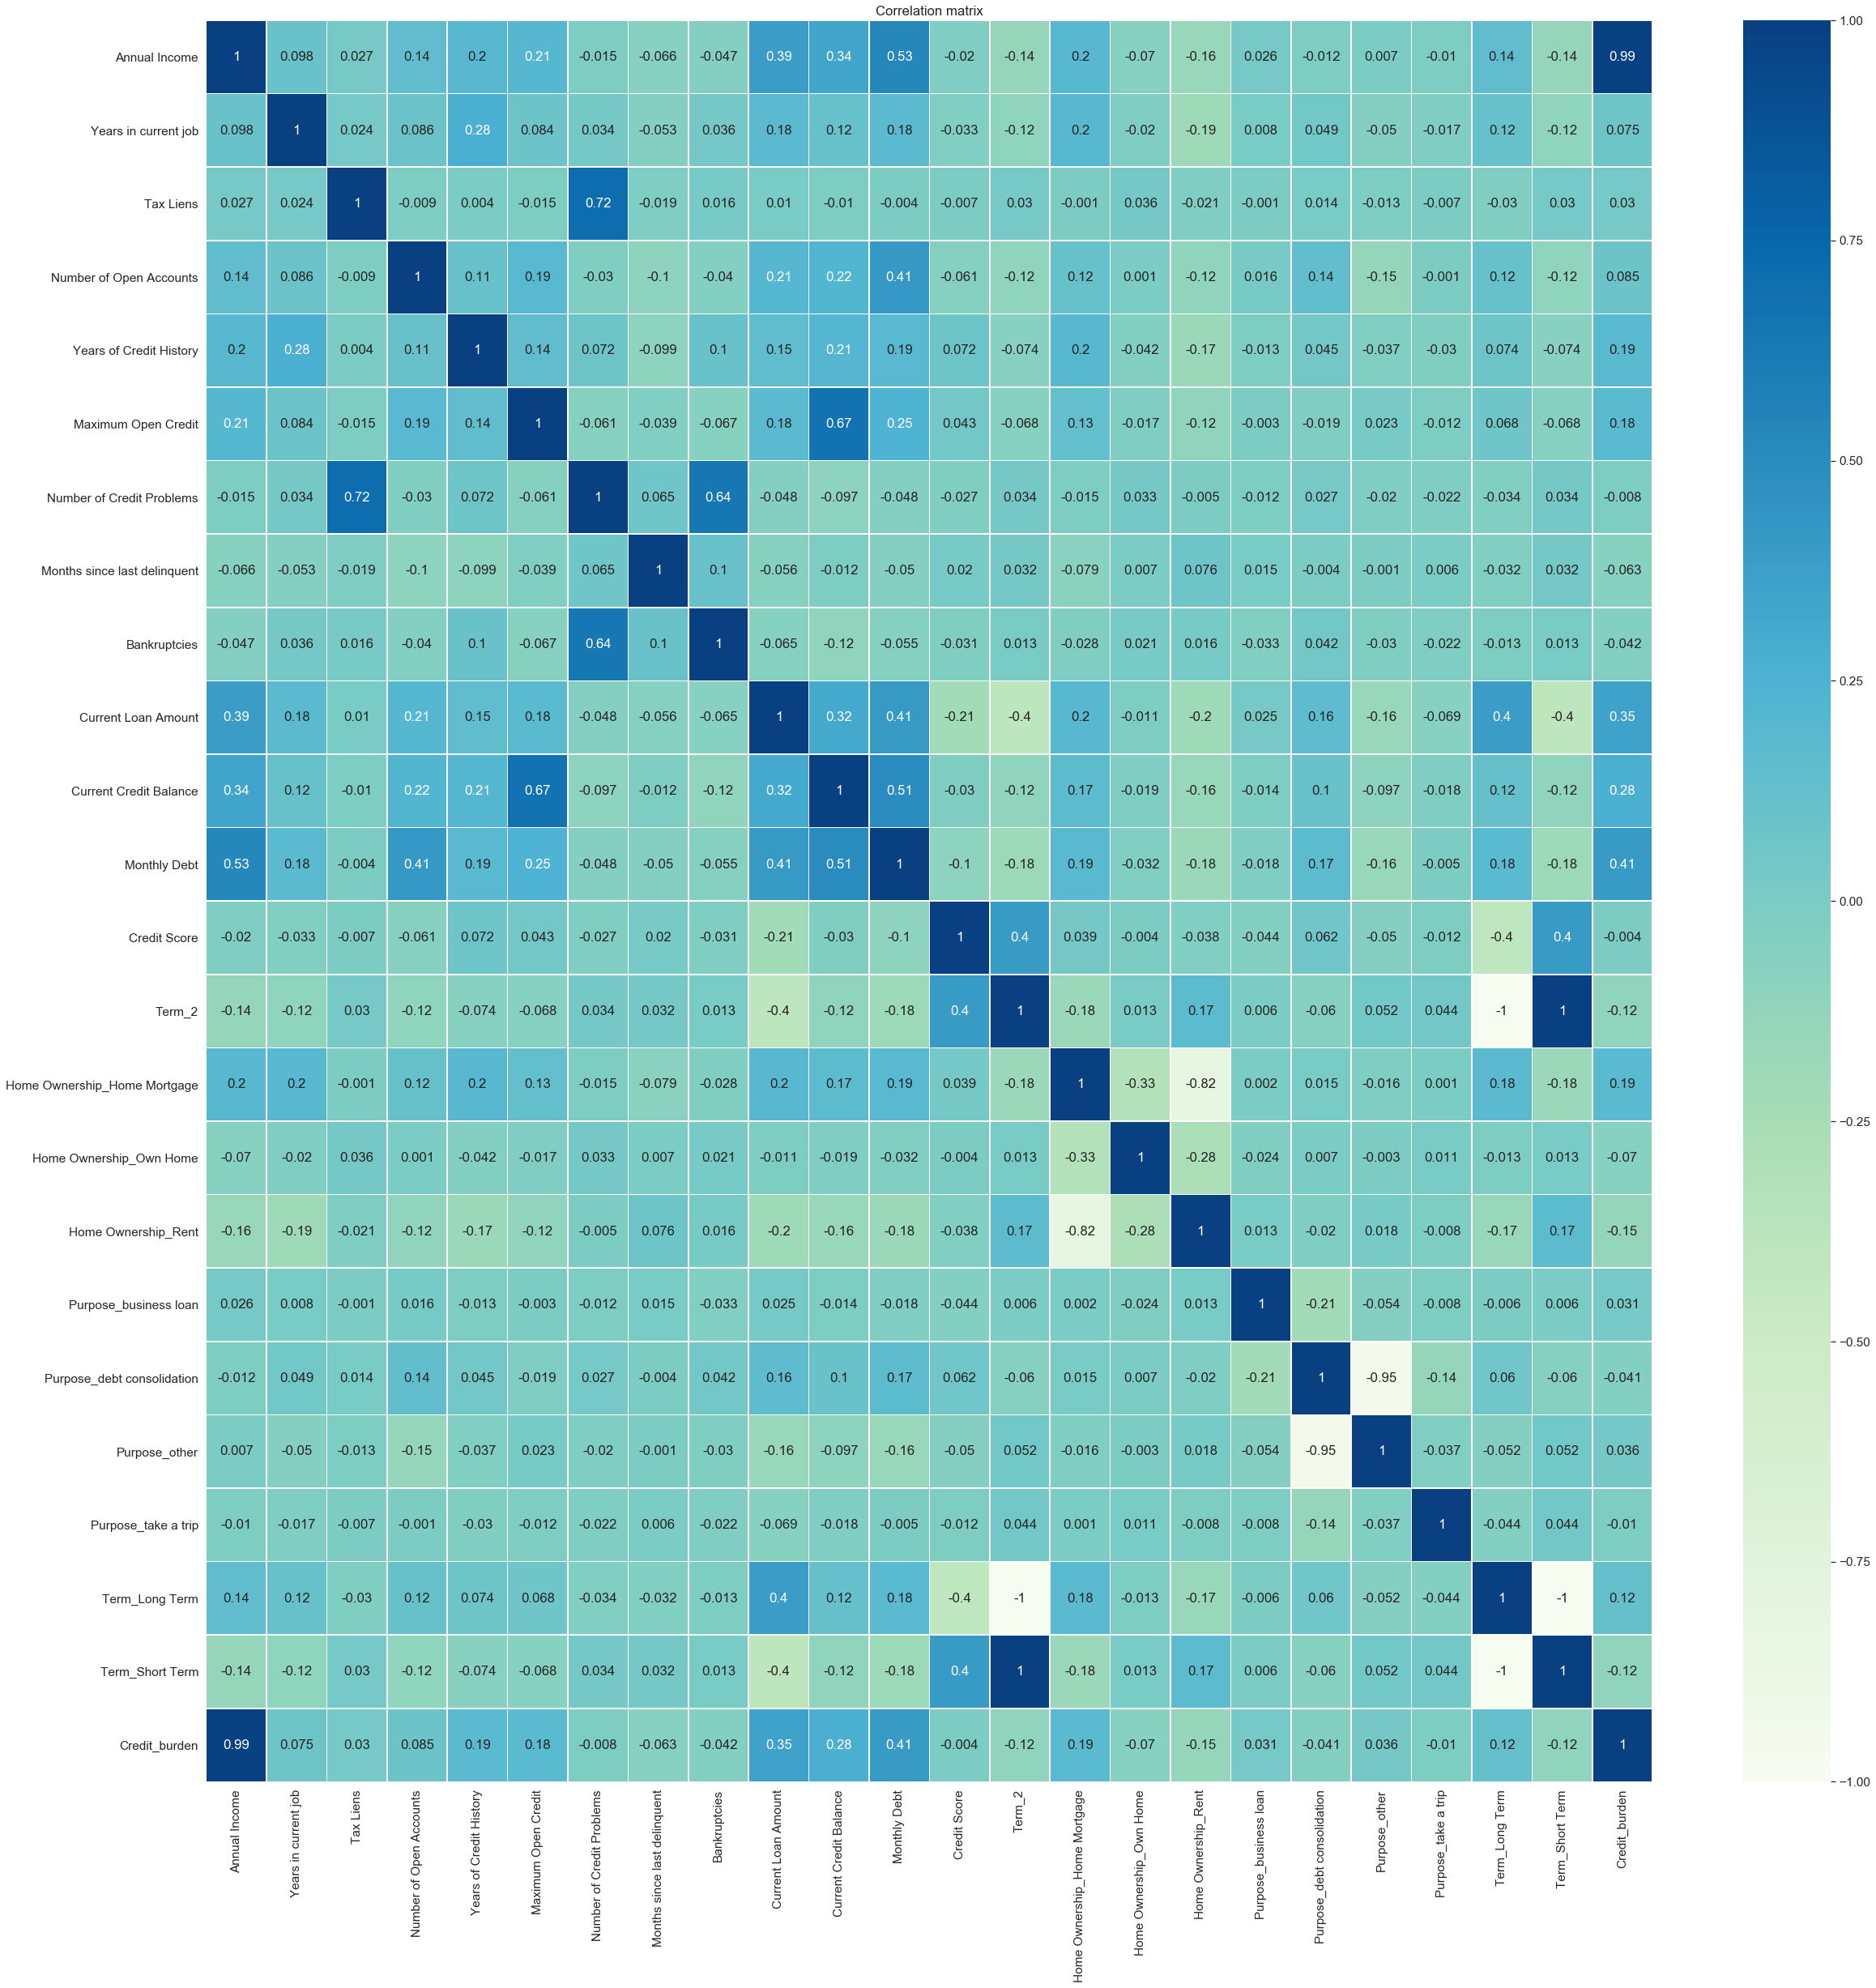

In [64]:
plt.figure(figsize = (40,40))

sns.set(font_scale=1.4)
sns.heatmap(df_test.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [65]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens', 
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Term_2',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan',
       'Purpose_debt consolidation', 'Purpose_other', 'Purpose_take a trip',
       'Credit_burden']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_FEATURE_NAMES

### Приведение типов для модели CatBoost

In [66]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

In [67]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df_norm_test = df_test.copy()
df_norm_test[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm_test[NUM_FEATURE_NAMES])

df = df_norm.copy()
df_test = df_norm_test.copy()

In [68]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разбиение на train и test

In [69]:
X = df.drop(['Credit Default', 'Home Ownership', 'Purpose', 'Term'], axis=1)
df_test = df_test.drop(['Home Ownership', 'Purpose', 'Term'], axis=1)
y = df[['Credit Default']]

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.35)


In [71]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    #print('CONFUSION MATRIX\n')
    #print(pd.crosstab(y_test, y_test_pred))

### Балансировка целевой переменной

In [72]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [73]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
print(df_balanced[TARGET_NAME].value_counts())

X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

0    3503
1    2744
Name: Credit Default, dtype: int64


In [74]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [75]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей
**Логистическая регрессия**

In [76]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3503
           1       0.60      0.40      0.48      2744

    accuracy                           0.62      6247
   macro avg       0.62      0.60      0.59      6247
weighted avg       0.62      0.62      0.61      6247

TEST

              precision    recall  f1-score   support

           0       0.77      0.80      0.79      1884
           1       0.44      0.40      0.42       741

    accuracy                           0.69      2625
   macro avg       0.60      0.60      0.60      2625
weighted avg       0.68      0.69      0.68      2625



**k ближайших соседей**

In [77]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3503
           1       0.73      0.66      0.70      2744

    accuracy                           0.75      6247
   macro avg       0.74      0.74      0.74      6247
weighted avg       0.75      0.75      0.74      6247

TEST

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1884
           1       0.37      0.45      0.41       741

    accuracy                           0.63      2625
   macro avg       0.57      0.57      0.57      2625
weighted avg       0.65      0.63      0.64      2625



**Бустинговые алгоритмы**

*XGBoost*

In [78]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3503
           1       1.00      1.00      1.00      2744

    accuracy                           1.00      6247
   macro avg       1.00      1.00      1.00      6247
weighted avg       1.00      1.00      1.00      6247

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1884
           1       0.50      0.44      0.46       741

    accuracy                           0.72      2625
   macro avg       0.64      0.63      0.64      2625
weighted avg       0.71      0.72      0.71      2625



*LightGBM*

In [79]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3503
           1       0.94      0.94      0.94      2744

    accuracy                           0.95      6247
   macro avg       0.95      0.95      0.95      6247
weighted avg       0.95      0.95      0.95      6247

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1884
           1       0.52      0.48      0.50       741

    accuracy                           0.73      2625
   macro avg       0.66      0.65      0.66      2625
weighted avg       0.72      0.73      0.72      2625



*CatBoost*

In [80]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      3503
           1       0.94      0.88      0.91      2744

    accuracy                           0.92      6247
   macro avg       0.93      0.92      0.92      6247
weighted avg       0.92      0.92      0.92      6247

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1884
           1       0.53      0.47      0.50       741

    accuracy                           0.73      2625
   macro avg       0.66      0.65      0.66      2625
weighted avg       0.72      0.73      0.73      2625



### Выбор лучшей модели и подбор гиперпараметров

In [81]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.58      0.73      3503
           1       0.65      1.00      0.79      2744

    accuracy                           0.76      6247
   macro avg       0.82      0.79      0.76      6247
weighted avg       0.85      0.76      0.76      6247

TEST

              precision    recall  f1-score   support

           0       0.88      0.46      0.60      1884
           1       0.38      0.84      0.52       741

    accuracy                           0.56      2625
   macro avg       0.63      0.65      0.56      2625
weighted avg       0.74      0.56      0.58      2625



In [82]:
params = {'n_estimators':[50, 100, 200, 300, 400, 500, 700, 900],
          'max_depth':[3, 4, 5, 6, 7]}

In [83]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [84]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 57.9 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000002235AE46988>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500, 700, 900]},
                   scoring='f1')

In [85]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 5}

In [86]:
rs.best_score_

0.5354861640690852

In [87]:
аываываываываыв

NameError: name 'аываываываываыв' is not defined

In [88]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5, learning_rate=0.01, 
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3503
           1       0.76      0.62      0.68      2744

    accuracy                           0.75      6247
   macro avg       0.75      0.73      0.74      6247
weighted avg       0.75      0.75      0.74      6247

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1884
           1       0.52      0.53      0.52       741

    accuracy                           0.73      2625
   macro avg       0.66      0.67      0.67      2625
weighted avg       0.73      0.73      0.73      2625

Wall time: 2.45 s


In [89]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5, learning_rate=0.01,
                                      l2_leaf_reg=10,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      3503
           1       0.75      0.61      0.67      2744

    accuracy                           0.74      6247
   macro avg       0.74      0.72      0.73      6247
weighted avg       0.74      0.74      0.73      6247

TEST

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1884
           1       0.51      0.52      0.51       741

    accuracy                           0.72      2625
   macro avg       0.66      0.66      0.66      2625
weighted avg       0.72      0.72      0.72      2625



In [90]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

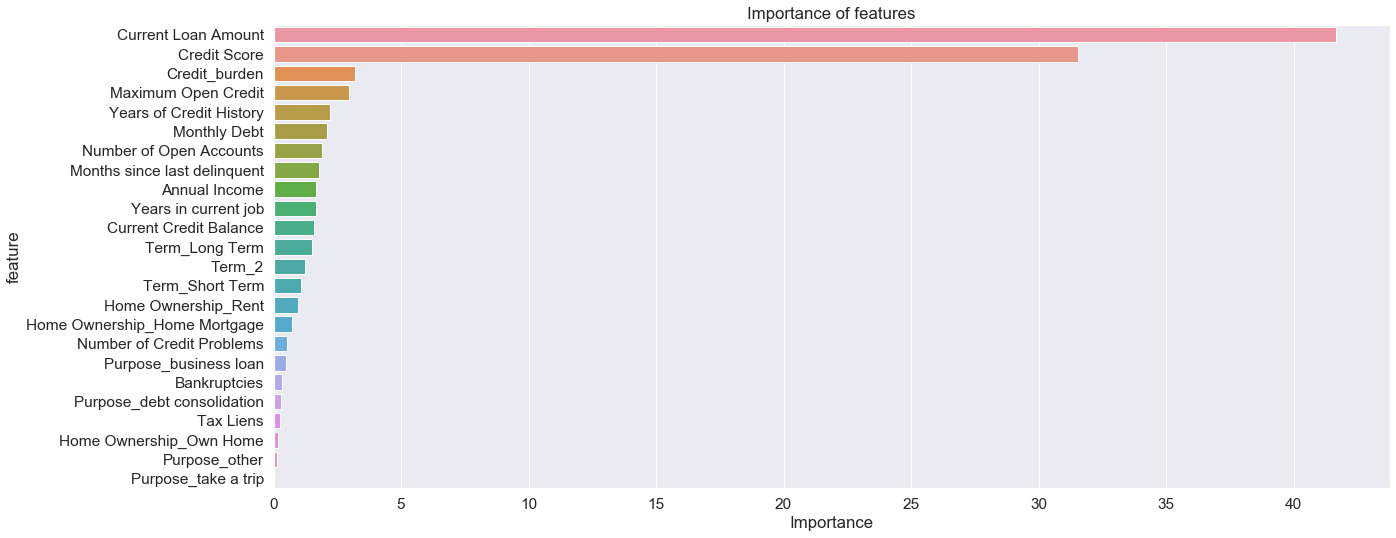

In [91]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=12)

In [92]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'Credit_burden',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Annual Income',
 'Years in current job',
 'Current Credit Balance',
 'Term_Long Term']

In [93]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=5, l2_leaf_reg=10, learning_rate=0.01,
                                      silent=True, random_state=21)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      3503
           1       0.74      0.61      0.67      2744

    accuracy                           0.74      6247
   macro avg       0.74      0.72      0.73      6247
weighted avg       0.74      0.74      0.73      6247

TEST

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1884
           1       0.51      0.50      0.51       741

    accuracy                           0.72      2625
   macro avg       0.66      0.66      0.66      2625
weighted avg       0.72      0.72      0.72      2625



In [94]:
y_test_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [95]:
y_pred = final_model.predict(df_test[important_features_top])
y_pred = pd.DataFrame(y_pred, columns=['Credit Default'])

print(y_pred.shape)

(2500, 1)


In [96]:
# 4.4. Экспорт результатов
import csv
filename = 'Kaldin_2.csv'
y_pred.to_csv(filename, index=None)

In [97]:
y_pred

,Credit Default
0,0
1,1
2,1
3,0
4,0
...,...
2495,0
2496,0
2497,1
2498,0
